In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-05-31 14:35:33.290640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 14:35:33.557423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 14:35:33.557458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 14:35:33.581909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 14:35:33.663098: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Emulated CV dataset

In [27]:
data_mode = 'emu'
statistics = ['pk']

tag_params = '_quijote_p0_n1000'
tag_biasparams = '_b1000_p0_n1'
tag_errG = '_boxsize1000'
n_rlzs_per_cosmo = 1
tag_noiseless = ''
#tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
kwargs_data = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                    'tag_errG': tag_errG,
                    'tag_datagen': tag_datagen,
                    'tag_noiseless': tag_noiseless}
    
tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [28]:
k_cv_emu, y_cv_emu, y_err_cv_emu, idxs_params_emu, params_df_cv_emu, param_dict_fixed_cv_emu, biasparams_df_cv_emu, biasparams_dict_fixed_cv_emu, random_ints_cosmo_cv_emu, random_ints_bias_cv_emu = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv_emu, y_cv_emu, y_err_cv_emu = k_cv_emu[0], y_cv_emu[0], y_err_cv_emu[0]

../data/emuPks/emuPks_quijote_p0_n1000_b1000_p0_n1/emuPks_noisy_boxsize1000_nrlzs1.npy
(1000, 30)
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_emu_pk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1.txt
Loading from ../data/masks/mask_emu_pk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1.txt (already exists)
Masked 0 out of 30 bins


In [29]:
params_dict_cv_emu = param_dict_fixed_cv_emu.copy()
params_dict_cv_emu.update(biasparams_dict_fixed_cv_emu)
print(params_dict_cv_emu)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [30]:
cov_fid_emu = np.cov(y_cv_emu, rowvar=False)
print(cov_fid_emu.shape)

(30, 30)


In [32]:
theta_fid = [params_dict_cv_emu[param] for param in utils.param_names_all_ordered]

## Generate fisher pks in notebook

In [7]:
tag_params = '_fisher_quijote'
tag_biasparams = '_fisher_biaszen'   

In [20]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
biasparams_df, biasparams_dict_fixed = data_loader.load_bias_params(tag_biasparams)

In [13]:
def combine_fisher_param_dfs(params_df, biasparams_df):
    """
    Combine cosmological and bias parameter DataFrames for Fisher analysis.
    For every non-fiducial row in params_df, combine with fiducial biasparams_df.
    For every non-fiducial row in biasparams_df, combine with fiducial params_df.
    The fiducial row is where 'param_shifted' == 'fiducial'.
    Adds columns 'idx_cosmo', 'idx_bias', 'param_shifted', and 'n_deltas' for the original indices and meta info.
    Returns a DataFrame where each row is the fiducial with only one parameter varied.
    """
    # Identify fiducial rows
    fiducial_params_row = params_df[params_df['param_shifted'] == 'fiducial'].iloc[0]
    fiducial_bias_row = biasparams_df[biasparams_df['param_shifted'] == 'fiducial'].iloc[0]

    # Get parameter names (excluding meta columns)
    param_cols = [c for c in params_df.columns if c not in ['param_shifted', 'n_deltas']]
    bias_cols = [c for c in biasparams_df.columns if c not in ['param_shifted', 'n_deltas']]

    # Start with the all-fiducial row
    rows = []
    fiducial_row = {**fiducial_params_row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
    fiducial_row['idx_cosmo'] = fiducial_params_row.name
    fiducial_row['idx_bias'] = fiducial_bias_row.name
    fiducial_row['param_shifted'] = 'fiducial'
    fiducial_row['n_deltas'] = 0
    rows.append(fiducial_row.copy())

    # For every non-fiducial row in params_df, combine with fiducial biasparams
    for idx, row in params_df[params_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
        combined['idx_cosmo'] = idx
        combined['idx_bias'] = fiducial_bias_row.name
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    # For every non-fiducial row in biasparams_df, combine with fiducial params
    for idx, row in biasparams_df[biasparams_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**fiducial_params_row[param_cols].to_dict(), **row[bias_cols].to_dict()}
        combined['idx_cosmo'] = fiducial_params_row.name
        combined['idx_bias'] = idx
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    all_param_names = param_cols + bias_cols + ['idx_cosmo', 'idx_bias', 'param_shifted', 'n_deltas']
    combined_df = pd.DataFrame(rows, columns=all_param_names)
    return combined_df

In [15]:
params_all_df = combine_fisher_param_dfs(params_df, biasparams_df)
print(len(params_df), len(biasparams_df), len(params_all_df))

21 17 37


In [16]:
# copied from fisher_muchisimocks notebook
def compute_derivatives_from_fisherset(params_df, pk_array, param_names,
                                       n_deltas_for_diff=1):
    """
    Compute derivatives of the power spectra using finite differences from the _fisher_quijote set.
    Assumes params_df has columns 'changed_param' and 'n_delta', and pk_array is aligned row-wise.
    Uses n_delta = n_deltas_for_diff and n_delta = -n_deltas_for_diff for each parameter.

    Returns:
        derivatives: dict of {param_name: derivative array (same shape as pk)}
    """
    derivatives = {}
    for param in param_names:
        # Find indices for n_delta = n_deltas_for_dif and n_delta = -n_deltas_for_diff for this parameter
        idx_plus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == n_deltas_for_diff)].index
        idx_minus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == -n_deltas_for_diff)].index
        if len(idx_plus) == 0 or len(idx_minus) == 0:
            raise ValueError(f"Missing n_delta=2 or n_delta=-2 for parameter {param}")
        pk_plus = pk_array[idx_plus[0]]
        pk_minus = pk_array[idx_minus[0]]
        delta_tot = params_df.loc[idx_plus[0], param] - params_df.loc[idx_minus[0], param]
        derivatives[param] = (pk_plus - pk_minus) / delta_tot
    return derivatives

In [21]:
def compute_emulated_pks(params_all_df, param_dict_fixed, emu, k_emu):
    """
    Compute emulated P(k) for each row in params_all_df.
    Returns: array of shape (n_samples, len(k_emu))
    """
    pks = []
    for _, row in params_all_df.iterrows():
        # Build parameter dicts
        cosmo_params = {pn: row[pn] for pn in utils.cosmo_param_names_ordered}
        cosmo_params.update(param_dict_fixed)
        bias_params = [row[bn] for bn in utils.biasparam_names_ordered]
        # Some emulators require specific param names, adapt as needed
        cosmo_params_emu = {utils.param_name_to_param_name_emu(k): v for k, v in cosmo_params.items()}
        cosmo_params_emu['expfactor'] = 1.0
        _, pk, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k_emu, **cosmo_params_emu)
        pks.append(pk)
    return np.array(pks)

In [18]:
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
k = np.logspace(np.log10(0.01), np.log10(0.4), 30)
y_emu = compute_emulated_pks(params_all_df, param_dict_fixed, emu, k)
print(y_emu.shape)

(37, 30)


In [24]:
derivatives_shift_emu_nd1 = compute_derivatives_from_fisherset(params_all_df, y_emu, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

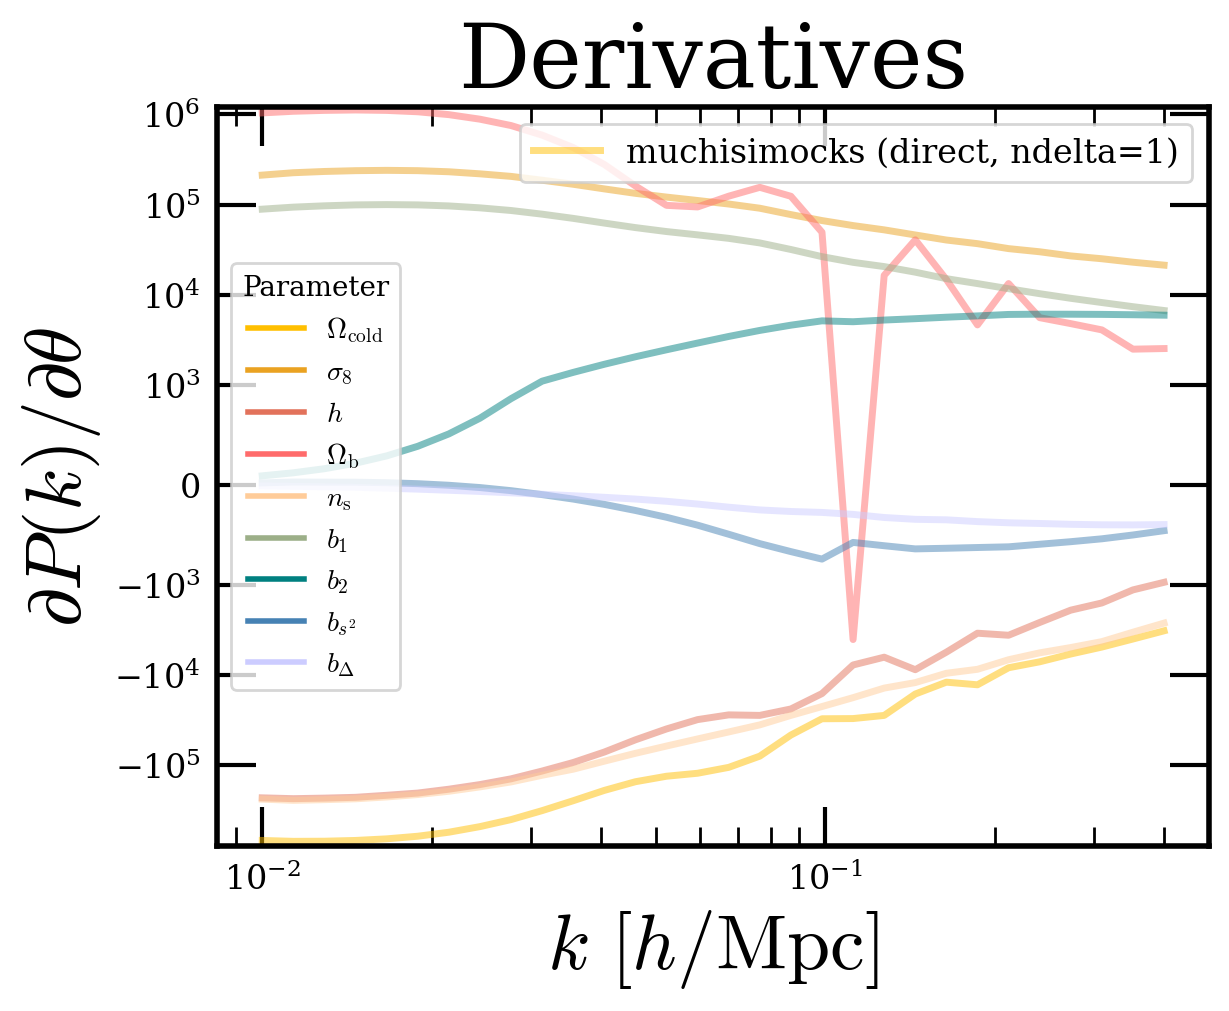

In [25]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k, derivatives_shift_emu_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    #plt.plot(k_biaszen, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

In [31]:
fisher_matrix_shift_emu_nd1 = utils.compute_fisher_matrix(derivatives_shift_emu_nd1, cov_fid_emu, utils.param_names_all_ordered)
cov_fisher_shift_emu_nd1 = np.linalg.inv(fisher_matrix_shift_emu_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_emu_nd1.shape)

Fisher matrix shape: (9, 9)


In [33]:
n_samples = 10000
samples_shift_emu_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_emu_nd1, size=n_samples)

In [35]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo('_p5_n10000')
_, dict_bounds_bias, _ = genp.define_LH_bias('_biaszen_p4_n10000')
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(extents)

{'omega_cold': [0.23, 0.4], 'omega_baryon': [0.04, 0.06], 'sigma8_cold': [0.65, 0.9], 'ns': [0.92, 1.01], 'hubble': [0.6, 0.8], 'neutrino_mass': [0.0, 0.4], 'w0': [-1.15, -0.85], 'wa': [-0.3, 0.3], 'b1': [-1.0, 2.0], 'b2': [-2.0, 2.0], 'bs2': [-2.0, 2.0], 'bl': [-10.0, 10.0]}


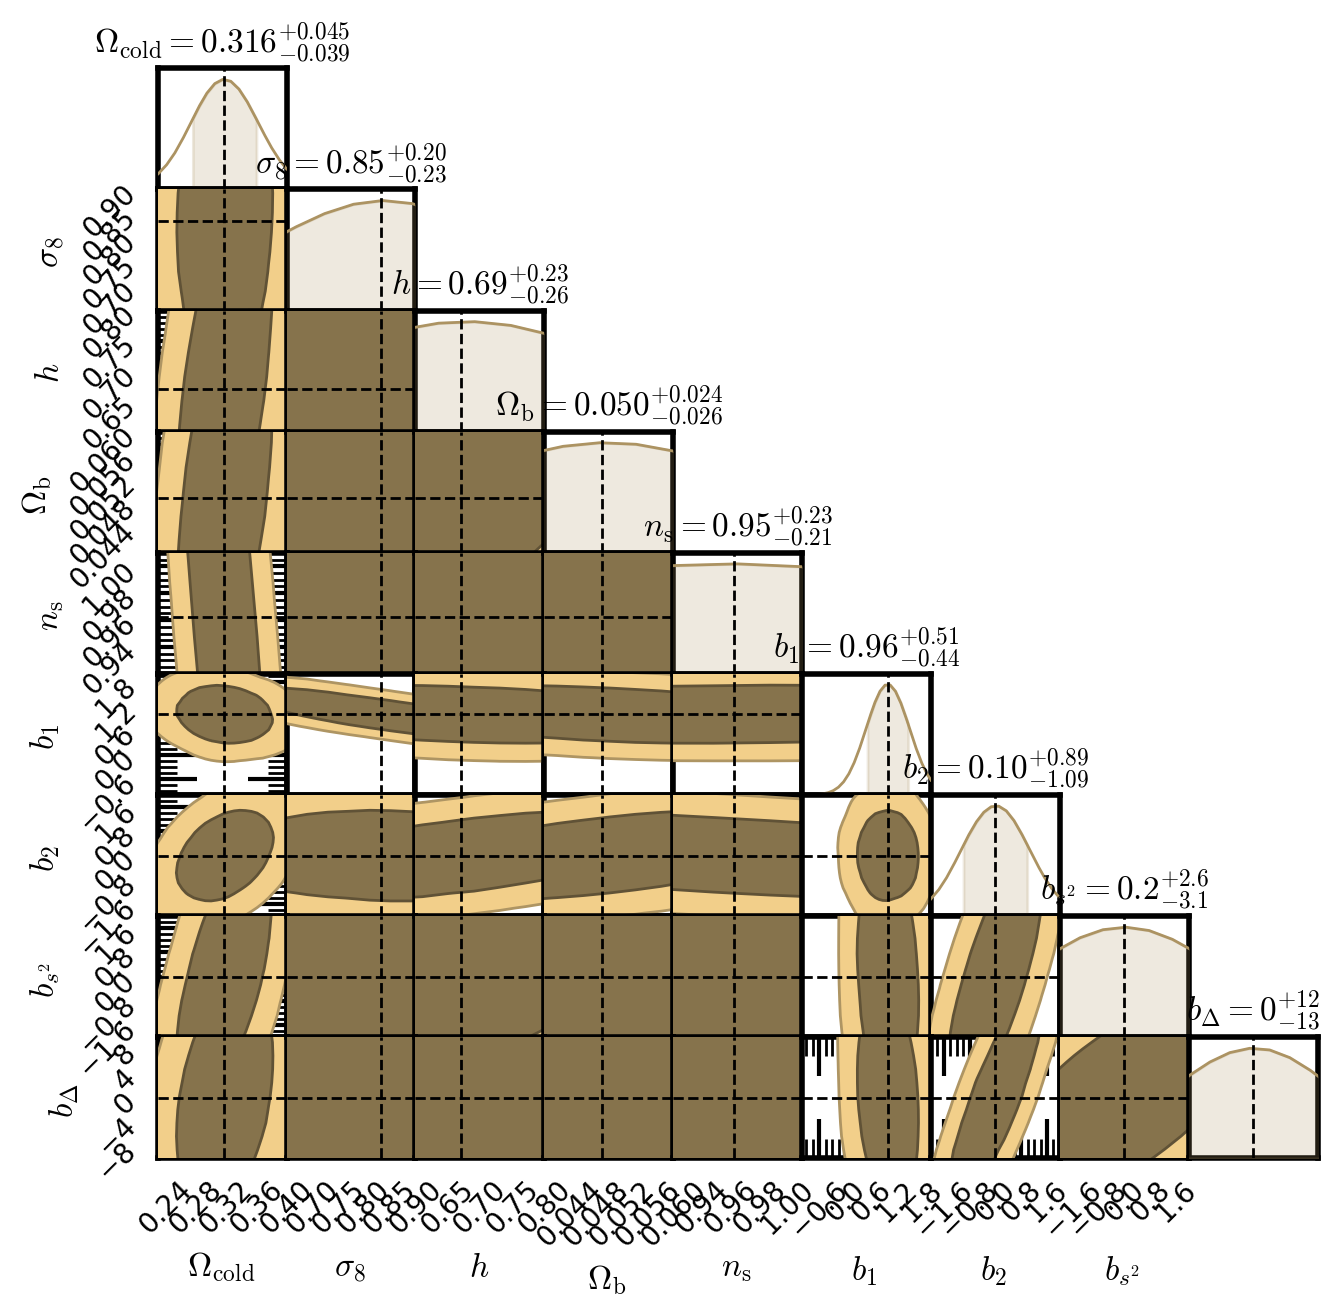

In [38]:

samples_arr = [samples_shift_emu_nd1, 
               #samples_shift_biaszen_nd2
               ]
labels = ['Fisher, emu, direct (n_delta=1)', 
          #'(n_delta=2)'
        ]
colors = ['#AC9362']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv_emu, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)